n= 5  train=0.001231  test=0.049891
n= 6  train=0.000786  test=0.022679
n= 7  train=0.000951  test=0.008400
n= 8  train=0.000619  test=0.008742
n= 9  train=0.000905  test=0.010799
n=10  train=0.000457  test=0.011890
n=11  train=0.000629  test=0.014190
n=12  train=0.000451  test=0.004551
n=13  train=0.000479  test=0.003608
n=14  train=0.000476  test=0.007053
n=15  train=0.000365  test=0.007889
n=16  train=0.000476  test=0.012884
n=17  train=0.000364  test=0.007007
n=18  train=0.000324  test=0.006932
n=19  train=0.000312  test=0.007795
n=20  train=0.000442  test=0.006257
n=21  train=0.000334  test=0.006123
n=22  train=0.000341  test=0.005530
n=23  train=0.000402  test=0.009783
n=24  train=0.000336  test=0.004730
n=25  train=0.000255  test=0.005798
Saved to /Users/anteravlic/Documents/research_2025/Lauren_2025/Lauren_emulator/figs/Emu1_alphaD_vs_n_train_test.pdf


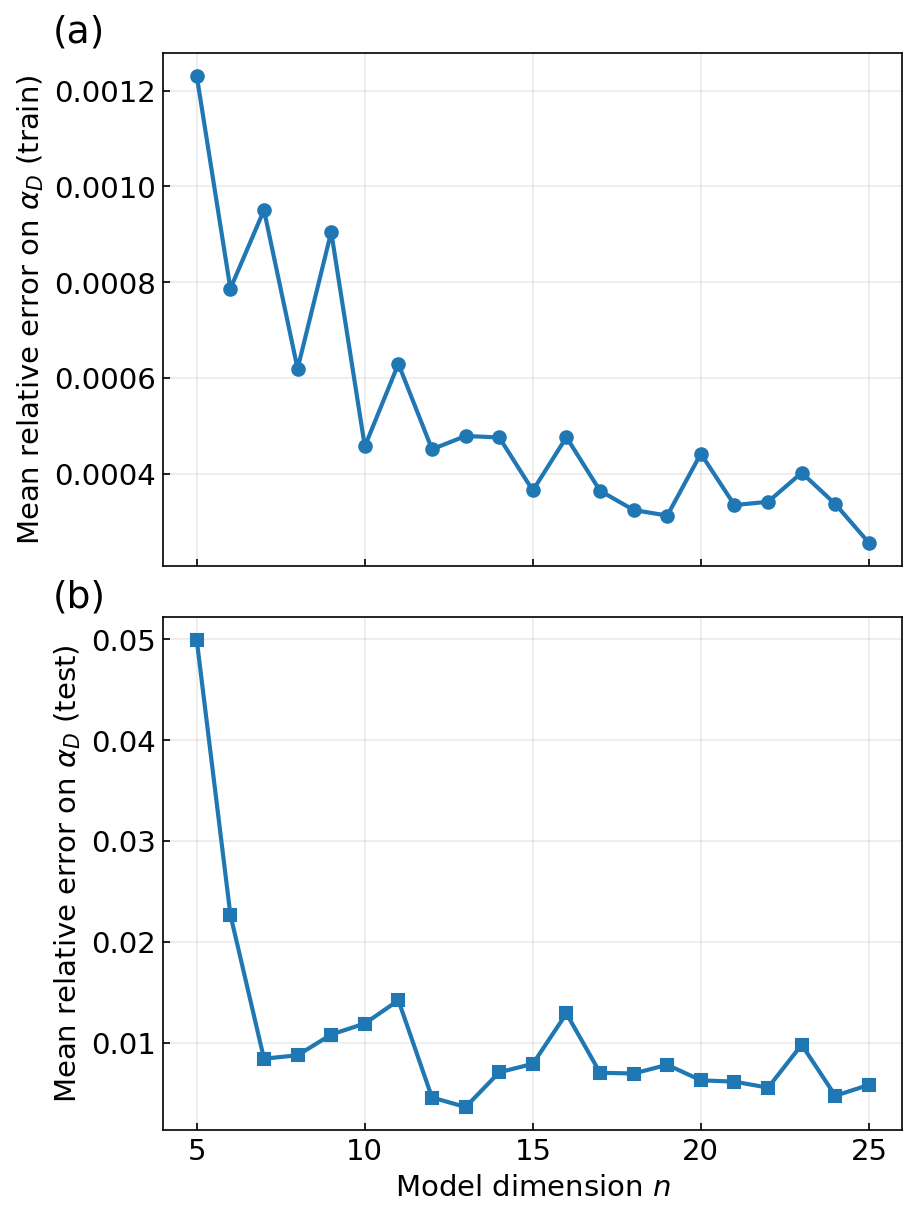

In [19]:
# === Emulator 1: alphaD mean relative error vs n on train/test regions (single two-panel figure) ===
import os, re, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# --- project helper import (adjust if needed) ---
try:
    sys.path.insert(0, str(Path("..").resolve()))
    from dipoles_exp_param import helper as helper
except Exception:
    import helper  # fallback if you're already in that package

# ---------------- config ----------------
retain = 0.6
n_list = list(range(5, 26))                 # n = 5..25
#n_list = [8,12,16]
runs_root = Path("../dipoles_exp_param/runs")
train_set_file = Path("../dipoles_exp_param/train_set.txt")
strength_dir = Path("../dipoles_data_all/total_strength")
alphaD_dir    = Path("../dipoles_data_all/total_alphaD")
out_fig = Path("Emu1_alphaD_vs_n_train_test.pdf")

# ---------------- load canonical train set & central point (as in your code) ----------------
train_set = []
with train_set_file.open("r") as f:
    for line in f:
        tup = tuple(map(str, line.strip().split(",")))
        if len(tup) == 2:
            train_set.append(tup)
train_set_set = set(train_set)

# central point computed from *train_set* (your original convention)
combined_ar = np.array(train_set, dtype=float)
centroid = combined_ar.mean(axis=0)
distances = np.linalg.norm(combined_ar - centroid, axis=1)
central_point = tuple(train_set[int(np.argmin(distances))])
c_alpha = float(central_point[0])
c_beta  = float(central_point[1])

# ---------------- pre-scan all available (alpha,beta) pairs & load data once ----------------
pattern = re.compile(r"^strength_([0-9.]+)_([0-9.]+)\.out$")
pairs = []            # list of (alpha_str, beta_str)
strength_list = []    # list of np.ndarray (E,S)
alphaD_list = []      # list of np.ndarray (metadata, alphaD value at [:,2] after vstack)

for fname in os.listdir(str(strength_dir)):
    m = pattern.match(fname)
    if not m:
        continue
    beta_str  = m.group(1)
    alpha_str = m.group(2)
    sfile = strength_dir / fname
    afile = alphaD_dir / f"alphaD_{beta_str}_{alpha_str}.out"
    if not afile.exists():
        continue
    # load once
    strength_arr = np.loadtxt(sfile)
    alphaD_arr   = np.loadtxt(afile)
    pairs.append((alpha_str, beta_str))
    strength_list.append(strength_arr)
    alphaD_list.append(alphaD_arr)

pairs = np.array(pairs, dtype=object)
strength_list = list(strength_list)
alphaD_list = list(alphaD_list)

# helpful index lists
is_train_mask = np.array([tuple(p) in train_set_set for p in pairs])
train_idx = np.where(is_train_mask)[0]
test_idx  = np.where(~is_train_mask)[0]

# ---------------- evaluation helper (your exact math) ----------------
def mean_rel_alphaD_for_indices(params_f32, n, idx_list):
    """
    Reproduce your evaluation:
      - build matrices via helper.modified_DS_affine_v(params, n)
      - form M_true(alpha,beta)
      - keep centered block (retain) of eigenpairs
      - compute v_eff, B, mask by (eig > 1)
      - make Lorentzians and alphaD_pred via helper.calculate_alphaD
      - return mean(|alphaD_pred - alphaD_true| / alphaD_true)
    """
    if len(idx_list) == 0:
        return np.nan

    # unpack paramization once per n
    (opt_D, opt_S1, opt_S2, opt_S3, opt_S4,
     opt_v0, opt_v1, opt_v2, fold, x1, x2, x3, x4) = helper.modified_DS_affine_v(params_f32, n)

    preds = []
    truths = []

    for k in idx_list:
        alpha_str, beta_str = pairs[k]
        a = tf.constant(float(alpha_str), dtype=tf.float32)
        b = tf.constant(float(beta_str),  dtype=tf.float32)

        exp1 = tf.exp(-(a - c_alpha) * x1)
        M_true = (opt_D
                  + (a - c_alpha) * opt_S1
                  + (b - c_beta)  * opt_S2
                  + (b - c_beta)  * exp1 * opt_S3)

        eigvals, eigvecs = tf.linalg.eigh(M_true)
        n_i = eigvals.shape[0]
        k_keep = int(round(retain * int(n_i)))
        k_keep = max(1, min(k_keep, int(n_i)))
        left = (int(n_i) - k_keep) // 2
        right = left + k_keep
        eigvals  = eigvals[left:right]
        eigvecs  = eigvecs[:, left:right]

        v_eff = opt_v0 + (a - c_alpha) * opt_v1 + (b - c_beta) * opt_v2
        proj = tf.linalg.matvec(tf.transpose(eigvecs), v_eff)
        B = tf.square(proj)

        mask = tf.cast((eigvals > 1.0), dtype=tf.float32)
        dot_products = B * mask

        x = strength_list[k][:, 0].astype(np.float32)
        eta_new = tf.sqrt(fold**2 + (x2 + x3*(a - c_alpha) + x4*(b - c_beta))**2)
        _Lor = helper.give_me_Lorentzian(x.astype(np.float32), eigvals, dot_products, eta_new)

        # alphaD: you used B (unmasked) in your script
        alphaD_pred = helper.calculate_alphaD(eigvals, B)
        preds.append(float(alphaD_pred.numpy()))
        truths.append(float(alphaD_list[k][2]))   # the 3rd column after vstack in your script

    preds = np.array(preds, dtype=float)
    truths = np.array(truths, dtype=float)
    return float(np.mean(np.abs(preds - truths) / truths))

# ---------------- sweep over n and collect metrics ----------------
means_train = []
means_test  = []

for n in n_list:
    # load params for this n
    pfile = runs_root / f"n{n}_r{retain}" / f"params_{n}_{retain}.txt"
    params = np.loadtxt(pfile).astype(np.float32)

    # compute train/test means (same code, different index lists)
    m_train = mean_rel_alphaD_for_indices(params, n, train_idx)
    m_test  = mean_rel_alphaD_for_indices(params, n, test_idx)

    print(f"n={n:2d}  train={m_train:.6f}  test={m_test:.6f}")
    means_train.append(m_train)
    means_test.append(m_test)

# ---------------- make the single two-panel figure ----------------
plt.rcParams.update({'font.size': 14, 'xtick.direction': 'in', 'ytick.direction': 'in'})
fig, ax = plt.subplots(2, 1, figsize=(6.0, 8.0), dpi=150, sharex=True, constrained_layout=True)

# (a) train
ax[0].plot(n_list, means_train, marker='o', lw=2)
ax[0].set_ylabel(r"Mean relative error on $\alpha_D$ (train)")
ax[0].grid(alpha=0.25)
ax[0].annotate("(a)", (-0.15, 1.02), xycoords="axes fraction", fontsize=18)

# (b) test
ax[1].plot(n_list, means_test, marker='s', lw=2)
ax[1].set_xlabel("Model dimension $n$")
ax[1].set_ylabel(r"Mean relative error on $\alpha_D$ (test)")
ax[1].grid(alpha=0.25)
ax[1].annotate("(b)", (-0.15, 1.02), xycoords="axes fraction", fontsize=18)

# Optional: if errors span decades, uncomment:
# ax[0].set_yscale("log"); ax[1].set_yscale("log")

fig.savefig(out_fig, bbox_inches="tight")
print(f"Saved to {out_fig.resolve()}")
plt.show()


0.04989135545326411
0.02267933081498019
0.00840037202030462
0.008741794596887478
0.010798919391046713
0.011889800701835219
0.014189877204338914
0.004551076153657037
0.003607536983718883
0.00705320844762651
0.007889150605701003
0.012884054926541936
0.007007482989670421
0.00693201578380768
0.007794684541197404
0.006257297961565832
0.0061234275022610165
0.005529501130871278
0.009783076131905877
0.004729582906756431
0.005797892493885223


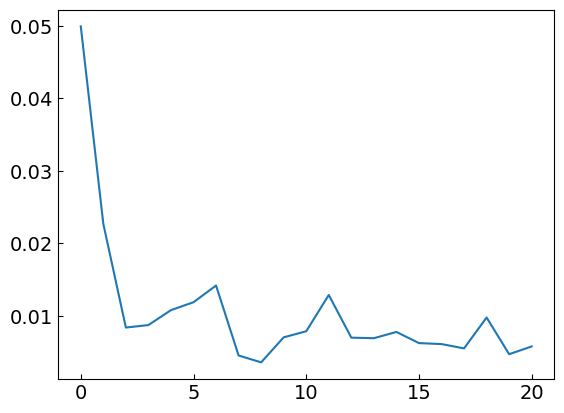

In [13]:
import tensorflow as tf

nn = [i for i in range(5,26)]
means = []

for n in nn:
    retain = 0.6

    params = np.loadtxt('../dipoles_exp_param/runs/n'+str(n)+'_r0.6/params_'+str(n)+'_'+str(retain)+'.txt')
    params = params.astype(np.float32)

    test_set = []
    with open("../dipoles_exp_param/train_set.txt", "r") as f:
        for line in f:
            tup = tuple(map(str, line.strip().split(",")))  # Convert back to tuple of integers
            test_set.append(tup)



    '''
    Calculate central point on train set
    '''
    # Compute centroid
    combined_ar = np.array(test_set, dtype = float)
    centroid = combined_ar.mean(axis=0)

    # Compute distances from each point to centroid
    distances = np.linalg.norm(combined_ar - centroid, axis=1)

    # Find index of closest point
    central_index = np.argmin(distances)
    central_point = tuple(test_set[central_index])
    #print('Central data point in train set:', central_point)

    strength = []
    alphaD = []
    fmt_data = []

    formatted_alpha_values = []
    formatted_beta_values = []

    strength_dir = '../dipoles_data_all/total_strength/'
    alphaD_dir = '../dipoles_data_all/total_alphaD/'

    # Pattern for strength files: strength_beta_alpha.out
    pattern = re.compile(r'strength_([0-9.]+)_([0-9.]+)\.out')

    for fname in os.listdir(strength_dir):
        match = pattern.match(fname)
        if match:
            beta = match.group(1)
            alpha = match.group(2)
            if ((alpha, beta)) not in test_set:
                #if ((alpha, beta)) not in test_set and ((alpha, beta)) not in cv_set:
                    #if ((float(beta_val) <= 4.0 and float(beta_val) >= 1.5) and (float(alpha_val) <= 1.8 and float(alpha_val) >= 0.4)):
                #if (float(alpha) > 0.5) :
                strength_file = os.path.join(strength_dir, fname)
                alphaD_file = os.path.join(alphaD_dir, f'alphaD_{beta}_{alpha}.out')

                if os.path.exists(alphaD_file):
                    # Read data
                    file_strength = np.loadtxt(strength_file)
                    file_alphaD = np.loadtxt(alphaD_file)


                    # Store
                    strength.append(file_strength)
                    alphaD.append(file_alphaD)
                    fmt_data.append((alpha, beta))

                    formatted_alpha_values.append(alpha)
                    formatted_beta_values.append(beta)



    # Example lists
    alpha = formatted_alpha_values
    beta = formatted_beta_values

    # Combine the lists into pairs
    #combined = [(x, y) for x in alpha for y in beta]
    combined = []
    for i in range(len(alpha)):
        combined.append((alpha[i], beta[i]))




    alphaD_opt = []
    opt_strength = []
    orig_strength = []
    opt_Bs = []
    opt_eigs = []


    for idx in range(len(combined)):

        alpha_tensor = tf.constant(float(combined[idx][0]), dtype=tf.float32)  # (batch,)
        beta_tensor  = tf.constant(float(combined[idx][1]), dtype=tf.float32)




        opt_D, opt_S1, opt_S2,opt_S3,opt_S4, opt_v0,opt_v1, opt_v2, fold, x1, x2, x3, x4 = helper.modified_DS_affine_v(params, n)
        #opt_eigenvalues, opt_eigenvectors = helper.generalized_eigen(opt_D.numpy(), opt_S1.numpy(), opt_S2.numpy(), combined[idx], central_point)
        exp1 = tf.exp( -(alpha_tensor- float(central_point[0])) * x1)


        M_true = opt_D + (alpha_tensor- float(central_point[0])) * opt_S1 \
                    + (beta_tensor- float(central_point[1])) * opt_S2 \
                    + (beta_tensor- float(central_point[1])) * exp1 * opt_S3  \
                    #+ beta_tensor * exp2 * opt_S4

        opt_eigenvalues, opt_eigenvectors = tf.linalg.eigh(M_true)

        n_i = opt_eigenvalues.shape[0]
        k_keep = int(round(retain * n_i))         # how many eigenvalues to keep
        k_keep = max(1, min(k_keep, n_i))         # safety: clamp between 1 and n

        left  = (n_i - k_keep) // 2               # starting index of the centered block
        right = left + k_keep                     # ending index (exclusive)

        opt_eigenvalues  = opt_eigenvalues[left:right]
        opt_eigenvectors = opt_eigenvectors[:, left:right]



        v_eff = opt_v0 \
             + (alpha_tensor- float(central_point[0])) * opt_v1 \
             + (beta_tensor- float(central_point[1])) * opt_v2 

        projections = tf.linalg.matvec(tf.transpose(opt_eigenvectors), v_eff)

        # Square each projection
        B = tf.square(projections)

        mask = tf.cast((opt_eigenvalues > 1), dtype=tf.float32)

        # Apply the mask to zero out B where eigenvalue is negative
        opt_dot_products = B * mask






        x = strength[idx][:,0]
        x = x.astype(np.float32)
        orig = strength[idx]
        orig_strength.append(orig)

        eta_new = tf.sqrt(fold**2 + (x2 + x3*(alpha_tensor- float(central_point[0])) + x4*(beta_tensor- float(central_point[1])))**2)

        opt_Lor = helper.give_me_Lorentzian(x, opt_eigenvalues, opt_dot_products, eta_new)

        opt_Bs.append(opt_dot_products)
        opt_eigs.append(opt_eigenvalues)

        opt_strength.append(opt_Lor)

        alphaD_opt.append(helper.calculate_alphaD(opt_eigenvalues, B))

        #plt.plot(x, opt_Lor, ls = '--')
        #print(combined[idx])
        #plt.plot(x, orig, ls = '-')

    alphaD_opt = np.array(alphaD_opt)







    # plot the points
    '''
    Discrepancy on plot with points
    '''
    alphaD = np.vstack(alphaD)
    x = [float(i) for i,j in combined]
    y = [float(j) for i,j in combined]
    print(np.mean(np.abs(alphaD_opt - alphaD[:,2])/alphaD[:,2]))
    means.append(np.mean(np.abs(alphaD_opt - alphaD[:,2])/alphaD[:,2]))

    
plt.plot(means)